# Assignment

## Library and Packages Import

In [95]:
%matplotlib inline

import csv, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from lib import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

## Data

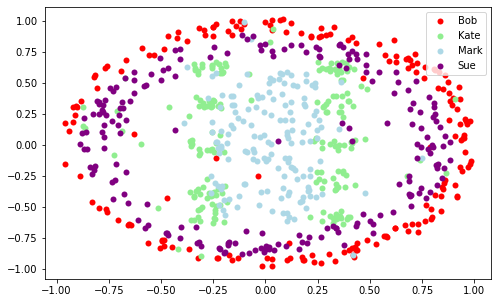

In [63]:
# Training data

file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X_train = X.astype(np.float64)
y_train = y.astype(np.float64)
file.close()

plt.figure(figsize=(8, 5))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_train[y_train == 2, 0], X_train[y_train == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_train[y_train == 3, 0], X_train[y_train == 3, 1], label='Sue', c='purple', linewidths=0)
plt.legend(loc='upper right')

In [67]:
print(f'Check Nan Value in X_train: {len(np.where(X_train==np.nan)[0])}')

Check Nan Value in X_train: 0


In [65]:
# Testing data

file = open('./test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X_test = X.astype(np.float64)
y_test = y.astype(np.float64)
file.close()

## Models

In [44]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, multi_class='multinomial')]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = 3, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])

### Voting

In [69]:
clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual Accuracy]')

for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(pipe, X_train, y_train, cv=10)
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual Accuracy]
LogisticRegression: 0.278 (+/- 0.038)
DecisionTree: 0.505 (+/- 0.034)
KNN: 0.821 (+/- 0.053)


In [68]:
print('[Voting]: weight combination')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]: weight combination
(0, 1, 2): 0.824 (+/- 0.053)
(0, 2, 1): 0.759 (+/- 0.043)
(1, 0, 2): 0.821 (+/- 0.050)
(1, 2, 0): 0.505 (+/- 0.034)
(2, 0, 1): 0.813 (+/- 0.062)
(2, 1, 0): 0.493 (+/- 0.042)

Best (0, 1, 2): 0.824


In [74]:
print('[Voting]: best model accuracy')
best_vt.fit(X_train, y_train)
y_pred_train = best_vt.predict(X_train)
y_pred_test = best_vt.predict(X_test)
print(f'Training: {accuracy_score(y_pred_train, y_train):.4f}')
print(f'Testing : {accuracy_score(y_pred_test, y_test):.4f}')

[Voting]: best model accuracy
Training: 0.8943
Testing : 0.7784


### Bagging

In [76]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=4, random_state=1)

In [78]:
# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.800
[Bagging] accuracy-train = 0.991, accuracy-test = 0.811


The result shows that Bagging can improve performance slightly.

### Boosting

In [116]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

# AdaBoost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[DecisionTree] accuracy-train = 0.370, accuracy-test = 0.292
[AdaBoost] accuracy-train = 0.615, accuracy-test = 0.530


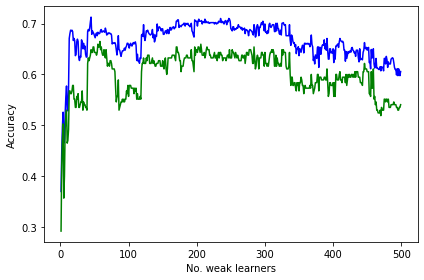

In [117]:
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=i, 
                             learning_rate=1, random_state=1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y_train, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))
        
plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [118]:
print(f'Highest training accuracy:{np.max(ada_train):.4f} with estimators={np.argmax(ada_train)}')
print(f'Highest training accuracy:{np.max(ada_test):.4f} with estimators={np.argmax(ada_test)}')

Highest training accuracy:0.7127 with estimators=44
Highest training accuracy:0.6649 with estimators=57


In [106]:
ada58 = AdaBoostClassifier(base_estimator=tree, n_estimators=58)
ada58.fit(X_train, y_train)
y_train_pred = ada58.predict(X_train)
y_test_pred = ada58.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost58] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[AdaBoost58] accuracy-train = 1.000, accuracy-test = 0.778


## Gridsearch

In [122]:
best_depth, best_test, best_train = 0, 0, 0

for depth in range(1, 31, 2):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=58)
    ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train = accuracy_score(y_train, y_train_pred)
    ada_test = accuracy_score(y_test, y_test_pred)
    if ada_test > best_test:
        best_depth, best_test, best_train = depth, ada_test, ada_train
    print(f'Depth={depth:2d}, train:{ada_train:.4f}, test:{ada_test:.4f}')
print(f'\nBest Model with depth {best_depth}:')
print(f'\tTraining Accuracy: {best_train:.4f}\n\tTesting Accuracy : {best_test:.4f}')

Depth= 1, train:0.6816, test:0.6649
Depth= 3, train:0.8171, test:0.6649
Depth= 5, train:0.9864, test:0.7676
Depth= 7, train:1.0000, test:0.8108
Depth= 9, train:1.0000, test:0.8054
Depth=11, train:1.0000, test:0.7946
Depth=13, train:1.0000, test:0.7946
Depth=15, train:1.0000, test:0.8486
Depth=17, train:1.0000, test:0.7784
Depth=19, train:1.0000, test:0.7622
Depth=21, train:1.0000, test:0.7784
Depth=23, train:1.0000, test:0.7838
Depth=25, train:1.0000, test:0.7784
Depth=27, train:1.0000, test:0.7622
Depth=29, train:1.0000, test:0.7784

Best Model with depth 15:
	Training Accuracy: 1.0000
	Testing Accuracy : 0.8486


## Brief Report
Voting and bagging both can improve the performance of simple model. After fine-tuning the adaboost model, I got the best testing peformance among all models with number of estimators equals to <b>58</b> and maximum depth of each tree is equal to <b>15</b>.